#1 Import library


In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

#2 Loading Data

In [2]:
r_cols = ["UserID", "MovieID", "Rating", "Timestamp"]
raw_data = pd.read_csv("/Applications/coding for life/semester4/ML/project/MachineLearning/dataset/ratings.dat", index_col = False ,delimiter="::",names = r_cols)

/var/folders/9m/q_st48_96nxbrmf463nr7q580000gn/T/ipykernel_25333/3314057822.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  raw_data = pd.read_csv("/Applications/coding for life/semester4/ML/project/MachineLearning/dataset/ratings.dat", index_col = False ,delimiter="::",names = r_cols)


In [3]:
raw_data

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


## Change DataFrame into matrix numpy

In [4]:
matrix_data = raw_data.to_numpy()


In [5]:
# Index of movie and user-1
matrix_data[:,[0,1]] = matrix_data[:,[0,1]] - 1
matrix_data

array([[        0,      1192,         5, 978300760],
       [        0,       660,         3, 978302109],
       [        0,       913,         3, 978301968],
       ...,
       [     6039,       561,         5, 956704746],
       [     6039,      1095,         4, 956715648],
       [     6039,      1096,         4, 956715569]])

In [6]:
# Splitting the data into training set and testing set
from sklearn.model_selection import train_test_split

rate_train, rate_test = train_test_split(matrix_data, test_size=0.33, random_state=42)
print(rate_train.shape, rate_test.shape)

(670140, 4) (330069, 4)


#3 Build the Matrix Fatorization Using Gradient Descent Method

In [8]:
class matrix_factorization(object):
  def __init__(self, data, nums_feature, lamda = 0.1, Xinit = None, Winit = None, 
               learning_rate = 0.5, max_iter = 1000, print_every = 1000, user_based = 1):
    self.raw_data = data
    self.K = nums_feature

    # regularization term:
    self.lamda = lamda

    #Learning rate:
    self.alpha = learning_rate

    # Print result after print_every iterations
    self.print_every = print_every

    # number of user, items, ratings:
    self.n_users = int(np.max(self.raw_data[:,0]) + 1)
    self.n_items = int(np.max(self.raw_data[:,1]) + 1)
    self.n_objects = int(self.raw_data.shape[0])

    # Numbers of iterations:
    self.max_iter = max_iter

    # Choose the way to normalize data:
    self.user_based = user_based

    # Initialize X matrix and W matrix:
    if Xinit is not None:
      self.X = Xinit
    else:
      self.X = np.random.rand(self.n_items,self.K)
    
    if Winit is not None:
      self.W = Winit
    else:
      self.W = np.random.rand(self.K,self.n_users)

    # Make a copy of raw matrix to prepare for normalize:
    self.normal_matrix = self.raw_data.copy()
    
  def normalize(self):
      """
      We normalize the rating matrix:
      For each users, we calculate the mean of rating of movies that user vote for. Then subtract the rating with that mean value.
      """
      if self.user_based:
        user_col = 0
        item_col = 1
        n_objects = self.n_users
      else:
        user_col = 1
        item_col = 0
        n_objects = self.n_items

      # # Convert all value in rating matrix to integer value:
      self.normal_matrix = self.normal_matrix.astype("float32")

      # Create a array contain mean value for each object:
      self.mean = np.zeros((n_objects,))
      # Compute mean and subtract rating for each user:
      for n in range(n_objects):
        # find index row rating which rated by user n or rate for movie n (depend on user_based or item_based)
        ids = np.where(self.normal_matrix[:,user_col] == n)

        # Find the rating column
        rating = self.normal_matrix[ids,2]
        # Find the mean of rating column
        mean_value = np.mean(rating)
        # Check whether mean_value is none or not (since sometime rating column is empty -> mean_value = NULL)
        if np.isnan(mean_value):
          mean_value = 0
        self.mean[n] = mean_value
        # normalize:
        self.normal_matrix[ids,2] =  self.normal_matrix[ids,2] - mean_value

  def movie_rated_by_user(self, user):
    """
    Return idex and matrix of movie column rated by the user
    """
    # find index row of movies which are rated by user i
    idx = np.where(self.normal_matrix[:,0] == user)

    # list of movie id which are rated by user i
    movieId = self.raw_data[idx,1].reshape((np.size(idx),))
      
    return idx[0], self.X[movieId,:]


  def user_rate_for_movie(self, movie):
    """
    Return idex and matrix of user row who rate for the movie
    """
    # find index row of user who rate for movie i
    idx = np.where(self.normal_matrix[:,1] == movie)

    # list of user id who rate for movie i 
    userId = self.raw_data[idx,0].reshape((np.size(idx),))
      
    return idx[0], self.W[:,userId] 


  def loss(self):
    """
    Compute the loss 
    """
    L = 0 
    for i in range(self.n_objects):
        # user, item, rating
        n, m, rate = int(self.normal_matrix[i, 0]), int(self.normal_matrix[i, 1]), self.normal_matrix[i, 2]
        L += 0.5*(rate - self.X[m, :].dot(self.W[:, n]))**2
    
    # take average
    L /= self.n_objects
    # regularization term 
    L += 0.5*self.lamda*(np.linalg.norm(self.X, 'fro') + np.linalg.norm(self.W, 'fro'))
    return L 

  def update_X(self):
    for movie in range(self.n_items):
      # find index column of users which rate for movie i and
      # list of user id who rate for movie i 
      idx,W = self.user_rate_for_movie(movie)
      actual_value = self.normal_matrix[idx,2]

      # Compute the predicted rating and error (1xn)
      predict = np.dot(self.X[movie,:], W)
      error = actual_value - predict
      # Update each row in X matrix
      self.X[movie,:] = self.X[movie,:] - self.alpha * ((-1/self.n_objects) * (np.dot(error, W.T)) + self.lamda * self.X[movie,:])
    
  def update_W(self):
    for user in range(self.n_users):
      # find index row of movie which is rated by user i
      # list of movie id which is rated by user i 
      idx,X = self.movie_rated_by_user(user)

       # Compute the predicted rating row with shape (K,1) and error
      actual_value = self.normal_matrix[idx,2]
      predict  = np.dot(X, self.W[:,user])
      error = actual_value - predict
      # Update each column in W matrix
      self.W[:,user] = self.W[:,user] - self.alpha * ((-1/self.n_objects) * (np.dot(X.T,error)) + self.lamda * self.W[:,user])


  def print(self, itr):
    print("Iteration",itr, ": " + "loss: ",self.loss() ,"RMSE train : ", self.MSE(self.raw_data))

  def fit(self):
    self.normalize()
    for iter in range(self.max_iter):
      self.update_X()
      self.update_W()

      if (iter + 1) % self.print_every == 0:
        self.print(iter+1)

  def predict(self,user,movie):
    predict = np.dot(self.X[movie,:], self.W[:,user])
    if self.user_based:
        predict = predict + self.mean[user]
    else:
      predict = predict + self.mean[movie]
    if predict < 0:
      predict = 0
    elif predict > 5:
      predict = 5
    return predict

  def MSE(self, rate_test):
    MSE = 0
    n_tests = rate_test.shape[0]
    for i in range(n_tests):
      pred = self.predict(rate_test[i,0], rate_test[i,1])
      error = (rate_test[i,2] - pred)**2
      MSE += error
    MSE = (1/(n_tests)) * MSE
    return MSE
      

  
      


    
    

        

#4 Visualize the accuracy of model

## With each value of iteration


In [9]:
iteration_list = [2,5,8,10,15,20]
MSE_train = []
MSE_test = []

In [10]:
for iter in iteration_list:
  mf = matrix_factorization(rate_train, nums_feature = 10, lamda = 0.1, learning_rate = 0.5,max_iter = iter, print_every = 1,user_based = 1)
  mf.fit()
  MSE_train.append(mf.MSE(rate_train))
  MSE_test.append(mf.MSE(rate_test))

Iteration 1 : loss:  15.406789579102998 RMSE train :  3.0832169890834575
Iteration 2 : loss:  14.29026373747018 RMSE train :  3.0011640187841375
Iteration 1 : loss:  15.356272945598985 RMSE train :  3.0673491415847947
Iteration 2 : loss:  14.24527980883946 RMSE train :  2.9834403539022354
Iteration 3 : loss:  13.259524527105754 RMSE train :  2.8781066232294408
Iteration 4 : loss:  12.379490111280292 RMSE train :  2.751617504642865
Iteration 5 : loss:  11.589185798800472 RMSE train :  2.606682803715684
Iteration 1 : loss:  15.462000995110746 RMSE train :  3.0845378407218895
Iteration 2 : loss:  14.335344328852479 RMSE train :  3.004178165014403
Iteration 3 : loss:  13.336698128382997 RMSE train :  2.9004635577303723
Iteration 4 : loss:  12.446019826974094 RMSE train :  2.773828405910016
Iteration 5 : loss:  11.646896088974986 RMSE train :  2.627876664906396
Iteration 6 : loss:  10.925847332695671 RMSE train :  2.468485067449565
Iteration 7 : loss:  10.271769753597741 RMSE train :  2.303

KeyboardInterrupt: 

In [ ]:
time_list = []
import time 
for i in [25,30,40,50]:
  iteration_list.append(i)
  mf = matrix_factorization(rate_train, nums_feature = 10, lamda = 0.1, learning_rate = 0.5,max_iter = i, print_every = 5,user_based = 1)
  start = time.time()
  mf.fit()
  MSE_train.append(mf.MSE(rate_train))
  MSE_test.append(mf.MSE(rate_test))
  end = time.time()
  time_list.append(end-start)




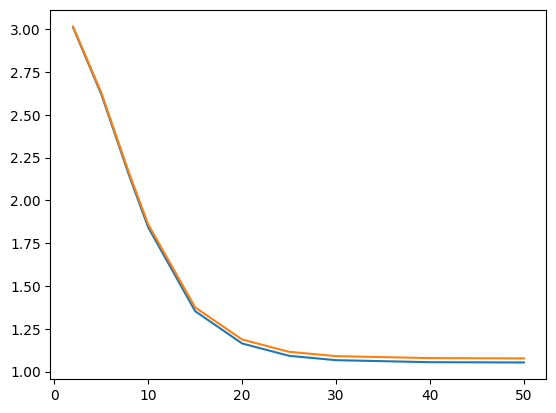

In [ ]:
plt.plot(iteration_list,MSE_train)
plt.plot(iteration_list, MSE_test)
plt.xlabel = "Iteration"
plt.ylabel ='Roots Mean Square Error'